C:\Users\ClementXu\anaconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ClementXu\anaconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


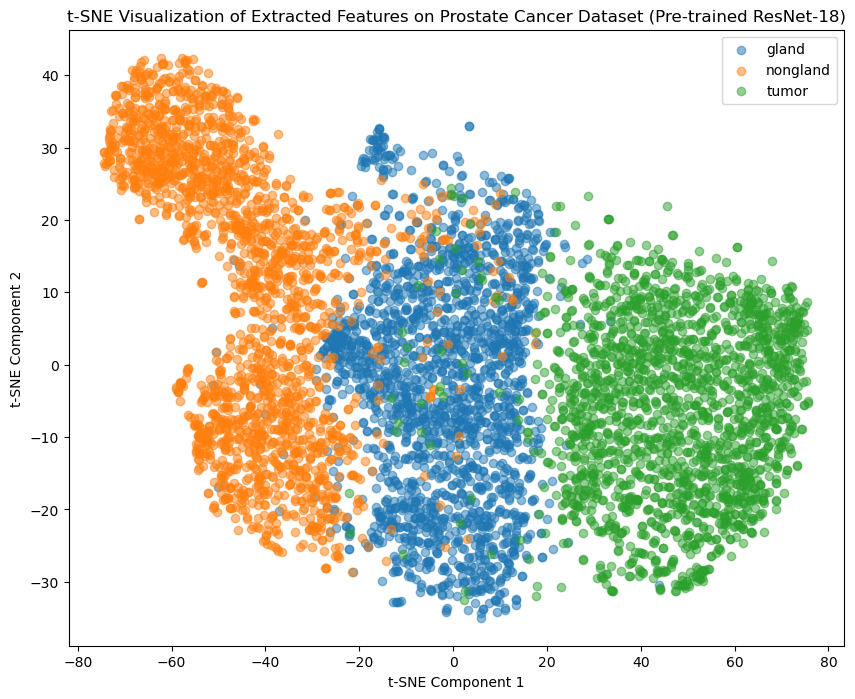

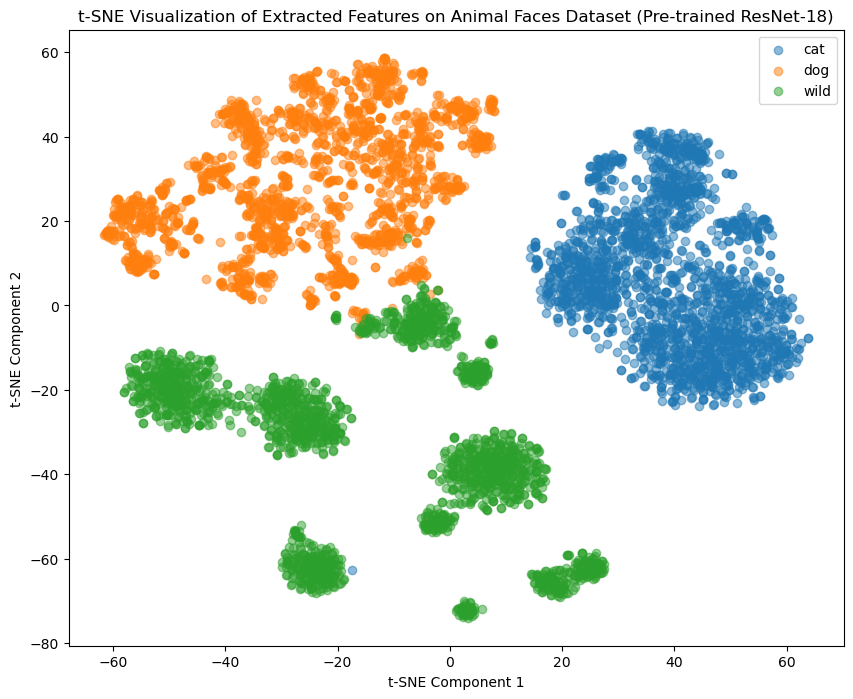

In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


class CustomResNet18(torch.nn.Module):
    def __init__(self, num_classes=3):
        super(CustomResNet18, self).__init__()
        resnet = models.resnet18(pretrained=True)  # Load the pre-trained ResNet-18 model from ImageNet
        self.features = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove the final classification layer

    def forward(self, x):
        x = self.features(x)  
        x = x.view(x.size(0), -1)  
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomResNet18().to(device)  
model.eval()  


# Data preprocessing: resizing the image, flipping, and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

# dataset2
dataset2_path = './Dataset2/ProstateCancer'
dataset2 = datasets.ImageFolder(root=dataset2_path, transform=transform)
data_loader2 = DataLoader(dataset2, batch_size=32, shuffle=False, num_workers=4)

# dataset3
dataset3_path = './Dataset3/AnimalFaces'
dataset3 = datasets.ImageFolder(root=dataset3_path, transform=transform)
data_loader3 = DataLoader(dataset3, batch_size=32, shuffle=False, num_workers=4)


# Function to extract features from the data using the model
def extract_features(data_loader, model):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for images, label in data_loader:
            images = images.to(device)  
            output = model(images)  
            features.append(output.cpu().numpy())  
            labels.append(label.numpy()) 
    features = np.concatenate(features) 
    labels = np.concatenate(labels)  
    return features, labels


# Extract features for Dataset 2 and Dataset 3
features2, labels2 = extract_features(data_loader2, model)
features3, labels3 = extract_features(data_loader3, model)

# Apply t-SNE for dimensionality reduction of the extracted features
tsne2 = TSNE(n_components=2, random_state=42)
reduced_features2 = tsne2.fit_transform(features2)

tsne3 = TSNE(n_components=2, random_state=42)
reduced_features3 = tsne3.fit_transform(features3)

# Visualize t-SNE results for Dataset 2
plt.figure(figsize=(10, 8))
for label in np.unique(labels2):
    idx = labels2 == label
    plt.scatter(reduced_features2[idx, 0], reduced_features2[idx, 1], label=dataset2.classes[label], alpha=0.5)
plt.legend()
plt.title("t-SNE Visualization of Extracted Features on Prostate Cancer Dataset (Pre-trained ResNet-18)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


# Visualize t-SNE results for Dataset 3
plt.figure(figsize=(10, 8))
for label in np.unique(labels3):
    idx = labels3 == label
    plt.scatter(reduced_features3[idx, 0], reduced_features3[idx, 1], label=dataset3.classes[label], alpha=0.5)
plt.legend()
plt.title("t-SNE Visualization of Extracted Features on Animal Faces Dataset (Pre-trained ResNet-18)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()
